In [3]:
import os
import re
import pandas as pd
import numpy as np
from scipy.stats import kruskal

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.patches as mpatches
from collections import Counter
from scipy.stats import pearsonr, spearmanr

import torch

from utils.llm_summarizer import Summarizer

import utils.params as P
from utils.fileIO import read_json2list, dump_list2json
from utils.publication import extract_valid_doi, is_valid_pmid, extract_valid_pmid, fetch_pmid_from_doi, link_pmid2pmcid, fetch_pmc_xml, get_openalex_citations_by_doi
from utils.dataset import label_data_availability_simple
from utils.other import listEntries_to_dictEntries, extract_key_structure
from utils.optimization import normalize_algorithms, method2category
from utils.constant import ADDED_FEATURES

torch.cuda.is_available()

True


# DOME Report
start at 13th May 2025

report DOC: https://docs.google.com/document/d/17rlxdggLQEpHaIhmuRAxY6Rzn9fB9BHuS-g5KQJ-9Rk/edit?tab=t.6kfax130q6i4


**Output Path**

In [2]:
path_figure0 = os.path.join(P.PATH_Output, "blankFieldCount.png") # The field was left blank
path_figure1 = os.path.join(P.PATH_Output, "skipFieldCount.png") # The field was left blank or answered 'NO' 
path_figure2 = os.path.join(P.PATH_Output, "scoreDistribution.png") # Score--Number_of_publications
path_figure3 = os.path.join(P.PATH_Output, "publications_per_year.png")
path_figure4 = os.path.join(P.PATH_Output, "curations_per_curator.png")
path_figure4_1 = os.path.join(P.PATH_Output, "curator_score_horizontal_boxplot.png")
path_figure5 = os.path.join(P.PATH_Output, "computational_methods_treemap.html")
path_figure6 = os.path.join(P.PATH_Output, "computational_methods_treemap.pdf")
path_table2 = os.path.join(P.PATH_Output, 'computational_methods_table.csv')
path_figure7 = os.path.join(P.PATH_Output, "ml_methods_by_year_percentage.png")

## 1. data preprocessing
13th May 2025

In [3]:
# load data
list_entries_org = read_json2list(P.path_registry_data_json)
print(f'Number of DOME Entries: {len(list_entries_org)}')

Number of DOME Entries: 317


### 1.0. basic info

In [4]:
print(len(list_entries_org[0].keys()))
for k, v in list_entries_org[0].items():
    print(f'{k}: {type(v)}')

16
_id: <class 'str'>
dataset: <class 'dict'>
evaluation: <class 'dict'>
model: <class 'dict'>
optimization: <class 'dict'>
user: <class 'dict'>
publication: <class 'dict'>
public: <class 'bool'>
created: <class 'str'>
updated: <class 'str'>
uuid: <class 'str'>
reviewState: <class 'str'>
shortid: <class 'str'>
update: <class 'int'>
__v: <class 'int'>
score: <class 'int'>


'user': curator's information. Curator is the person who submitted this paper/project

In [24]:
list_entries_org[0]['user']

{'_id': '6312169df3794236aa987a03',
 'email': 'martina.bevilacqua1992@gmail.com',
 'name': 'Martina',
 'orcid': '0000-0001-7619-871X',
 'surname': 'Bevilacqua',
 'roles': 'user',
 'organisation': 'undefined',
 'organizations': ['academia']}

4 main areas & their sub-areas (AREA_NAME -- KEY)

Data -- 'dataset', 4 sub-areas
> 'availability', 'provenance', 'redundancy', 'splits'

Optimization -- 'optimization', 8 sub-areas
> 'algorithm', 'config', 'encoding', 'features', 'fitting', 'meta', 'parameters', 'regularization'

Model -- 'model', 4 sub-areas
> 'availability', 'duration', 'interpretability', 'output'

Evaluation -- 'evaluation', 5 sub-areas
> 'availability', 'comparison', 'confidence', 'measure', 'method'

**There is no score for some records. Add score if there is no score availabel.**

In [ ]:
list_4area = ['dataset', 'optimization', 'model', 'evaluation']

for entry in list_entries_org:
    if 'score' not in entry:
        print(entry['_id'])
        entry['score'] = sum([entry[area]['done'] for area in list_4area])

**Delete the entries where score=0**

In [ ]:
test_samples = []
for entry in list_entries_org:
    if entry['score']==0:
        test_samples.append(entry['_id'])

list_entries_updated = [entry for entry in list_entries_org if entry['_id'] not in test_samples]
len(list_entries_updated)

**Save the new JSON**

In [40]:
dump_list2json(list_entries_updated, P.path_registry_data_processed_json)

### 1.1. Pulication: download Full Texts from PubMed

1. Link PMID to PMCID, check if PMCID is availabel.

2. if PMCID availabel, download the text from PubMed Central (full text)

3. else ....

In [5]:
list_entries_org[0]['publication']

{'pmid': '32344344',
 'updated': '03/22/2022 11:54:11',
 'authors': 'Bouysset C, Belloir C, Antonczak S, Briand L, Fiorucci S',
 'journal': 'Food Chem',
 'title': 'Novel scaffold of natural compound eliciting sweet taste revealed by machine learning.',
 'doi': '10.1016/j.foodchem.2020.126864',
 'year': '2020',
 'done': 0,
 'skip': 0,
 'tags': []}

Check the avalibility of PMID, some of them are not availabel especially for the early registrations.

So, first, clean DOI, then get PMID through DOI

#### a. get Clear DOI (code need to be updated if there are new user free styles in the future)
styles of availabel DOI:

>10.1186/1471-2105-8-S5-S3 \
https://doi.org/10.48550/arXiv.2202.05146 \
doi.org/10.48550/arXiv.2202.05146 \
doi: 10.48550/arXiv.2202.05146


In [ ]:
list_entries = read_json2list(P.path_registry_data_processed_json)

In [6]:
for e in list_entries:
    print(e['publication']['clear_doi'])
    

10.1016/j.foodchem.2020.126864
10.1186/1471-2105-9-s12-s18
10.1093/bioinformatics/btn189
10.3934/mbe.2019123
10.1002/art.40810
10.1186/s12859-019-2679-7
10.1128/msystems.00058-19
10.1016/j.ymeth.2019.03.004
10.1261/rna.074161.119
10.1093/jnci/djz112
10.1016/j.ebiom.2020.103042
10.1186/s13059-020-02075-3
10.1186/s40364-020-00215-2
10.1038/s41416-019-0694-0
10.1016/j.foodchem.2020.126864
10.1371/journal.pcbi.1009193
10.1038/s41467-021-24150-4
10.1002/prot.25798
10.1096/fj.201901529r
10.1016/j.cels.2019.05.004
10.1038/s41398-020-00957-5
10.1155/2020/1384749
10.1109/jbhi.2021.3104629
10.1371/journal.pone.0231172
10.3390/metabo10090357
10.1186/s12885-021-08647-1
10.1038/s41593-020-00733-0
10.1083/jcb.202006180
10.1038/s41467-021-22869-8
10.1038/s41467-021-23663-2
10.1080/07391102.2016.1163294
10.1186/1471-2105-10-25
10.1186/1471-2105-13-211
10.1136/annrheumdis-2011-200968
10.3168/jds.2012-5630
10.1094/phyto-04-17-0162-r
10.1152/ajprenal.00104.2018
10.1155/2018/3635845
10.1093/nar/gky889
10.

In [ ]:
for entry in list_entries:
    entry['publication']['clear_doi'] = extract_valid_doi(entry['publication']['doi'])
    entry['publication']['clear_pmid'] = extract_valid_pmid(entry['publication']['pmid'])

#### b. Fetch PMID from DOI 

In [ ]:
doi_not_fetch_pmid = []

for entry in list_entries:
    pmid = entry['publication']['clear_pmid']
    doi = entry['publication']['clear_doi']
    
    if doi=='':
        continue
    
    f_pmid = fetch_pmid_from_doi(doi)
    
    if is_valid_pmid(f_pmid):
        if pmid=='':
            entry['publication']['clear_pmid'] = f_pmid
        elif not pmid==f_pmid:
            print(f"{entry['_id']}: f_pmid({f_pmid}) and pmid({pmid} don't match).")
    else:
        doi_not_fetch_pmid.append(entry['_id'])
        print(f"{entry['_id']}: f_pmid is not availabel.")

No PMID found for DOI: 10.1101/2023.01.27.525827
644f21f3bcc9ba89a8f2c9e5: f_pmid is not availabel.
No PMID found for DOI: 10.1101/2021.07.17.452800
64541a9dbcc9ba89a8f2ca22: f_pmid is not availabel.
No PMID found for DOI: 10.1101/2021.07.17.452800
645aa34160bf612a3caabc1b: f_pmid is not availabel.
No PMID found for DOI: 10.1101/2024.02.12.579993
65d7e78d1502715bfe53c582: f_pmid is not availabel.
No PMID found for DOI: 10.48550/arxiv.2202.05146
6634f526ded6e7820f74a1b8: f_pmid is not availabel.
No PMID found for DOI: 10.1101/2024.10.04.616624
67339149a96b586fdb2723a9: f_pmid is not availabel.
No PMID found for DOI: 10.1093/gigascience/giaf037
6760e79869b4c4f264235d59: f_pmid is not availabel.
No PMID found for DOI: 10.1093/gigascience/giaf039
6780005469b4c4f26423614a: f_pmid is not availabel.
No PMID found for DOI: 10.1101/2024.11.06.24316844
6786955b69b4c4f2642362e8: f_pmid is not availabel.
No PMID found for DOI: 10.1101/2024.11.06.24316844
67892c3e69b4c4f26423638e: f_pmid is not ava

**Check if the match is correct**

It is correct.

In [ ]:
dict_entries = listEntries_to_dictEntries(list_entries)
    
for _id in doi_not_fetch_pmid:
    print(dict_entries[_id]['publication']['clear_pmid'], dict_entries[_id]['publication']['pmid'] )

 N/A
 Not yet assigned
 Not yet assigned
 na
 No
 n/a
 not yet published
 
 
 
 
 
 
 
 
 
 
 
 
 
 n/a
 
 
 
 


#### c. Link PMID to PMCID

In [ ]:
for entry in list_entries:
    pmid = entry['publication']['clear_pmid']
    if pmid=='':
        entry['publication']['pmcid'] = ''
    else:
        entry['publication']['pmcid'] = link_pmid2pmcid(pmid)

This article is not available in PMC.
Found PMCID: PMC2638158
Found PMCID: PMC2665034
This article is not available in PMC.
Found PMCID: PMC9328381
Found PMCID: PMC6394031
Found PMCID: PMC6495231
Found PMCID: PMC6708480
Found PMCID: PMC7297119
Found PMCID: PMC7073919
Found PMCID: PMC7648120
Found PMCID: PMC7333383
Found PMCID: PMC7520974
Found PMCID: PMC7054390
This article is not available in PMC.
Found PMCID: PMC8336795
Found PMCID: PMC8225676
Found PMCID: PMC6851483
Found PMCID: PMC6902683
Found PMCID: PMC6715517
Found PMCID: PMC7442807
Found PMCID: PMC7142336
Found PMCID: PMC8843059
Found PMCID: PMC7162491
Found PMCID: PMC7569858
Found PMCID: PMC8351329
This article is not available in PMC.
Found PMCID: PMC7816647
Found PMCID: PMC8100175
Found PMCID: PMC8185002
This article is not available in PMC.
Found PMCID: PMC2660303
Found PMCID: PMC3542245
Found PMCID: PMC3396452
This article is not available in PMC.
This article is not available in PMC.
Found PMCID: PMC6172579
Found PMCID: P

#### d. save new JSON file

In [ ]:
dump_list2json(list_entries, P.path_registry_data_processed_json)

#### f. download full text if PMCID availabel

In [ ]:
list_entries = read_json2list(P.path_registry_data_processed_json)

In [ ]:
for entry in list_entries:
    pmcid = entry['publication']['pmcid']
    if not pmcid=='':
        fetch_pmc_xml(pmcid, P.PATH_Registry_PMC_Full_Texts)

Saved XML to /home/dimeng/project/MLit-Triage-Nextflow/data/DOME_Registry_PMC_Full_Texts/PMC2638158.xml
Saved XML to /home/dimeng/project/MLit-Triage-Nextflow/data/DOME_Registry_PMC_Full_Texts/PMC2665034.xml
Saved XML to /home/dimeng/project/MLit-Triage-Nextflow/data/DOME_Registry_PMC_Full_Texts/PMC9328381.xml
Saved XML to /home/dimeng/project/MLit-Triage-Nextflow/data/DOME_Registry_PMC_Full_Texts/PMC6394031.xml
Saved XML to /home/dimeng/project/MLit-Triage-Nextflow/data/DOME_Registry_PMC_Full_Texts/PMC6495231.xml
Saved XML to /home/dimeng/project/MLit-Triage-Nextflow/data/DOME_Registry_PMC_Full_Texts/PMC6708480.xml
Saved XML to /home/dimeng/project/MLit-Triage-Nextflow/data/DOME_Registry_PMC_Full_Texts/PMC7297119.xml
Saved XML to /home/dimeng/project/MLit-Triage-Nextflow/data/DOME_Registry_PMC_Full_Texts/PMC7073919.xml
Saved XML to /home/dimeng/project/MLit-Triage-Nextflow/data/DOME_Registry_PMC_Full_Texts/PMC7648120.xml
Saved XML to /home/dimeng/project/MLit-Triage-Nextflow/data/DOME

### 1.2. Dataset

In [26]:
list_entries = read_json2list(P.path_registry_data_processed_json)
dict_entries = listEntries_to_dictEntries(list_entries)

In [28]:
list_entries[3]['dataset']

{'availability': 'Yes (GEO: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE152075)',
 'provenance': 'Data source:  Gene expression profiles from NCBI/GEO GSE152075.  Data points: 484 individuals.  N_pos (swabs Covid positive)= 430, N_neg (swabs Covid negative)= 34.  Used by at least one previous paper (PMID: 32898168).   ',
 'redundancy': '',
 'splits': 'Due to sample imbalance, the python package imblearn was used to amplify the number of small samples to the same as that of large samples.  ',
 'done': 3,
 'skip': 1,
 'availability_label': 'Y'}

In [29]:
for entry in list_entries:
    print(entry['_id'])
    print(entry['dataset']['availability_label'])
    print(entry['dataset']['availability'])
    print('-'*20)
    

63516fedb9c880af1f305b1b
N

--------------------
63516fedb9c880af1f305b1c
Y
Yes :  data to reproduce the results can be downloaded from GitHub (https://github.com/ggonzalezp/hyperfoods).  All data were extracted from publicly available databases.
--------------------
63516fedb9c880af1f305b1d
N
The materials, data, code and associated protocols are available to readers with application to the corresponding author and Waitemata privacy, security and governance group with a limited data sharing agreement.     
--------------------
63516fedb9c880af1f305b1e
Y
Yes (GEO: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE152075)
--------------------
63516fedb9c880af1f305b1f
Y
All data included in this study is available upon request at ELIXIR Luxemburg ( https://doi.org/10.17881/th9v-xt85 )
--------------------
63516fedb9c880af1f305b20
Y
Yes, Data are available from the Clinical Research Committee of KOBIO under the Korean College of Rheumatology for researchers who meet the criteria for a

In [ ]:
dict_entries['63516fedb9c880af1f305b5f']['dataset']

{'availability': '?',
 'provenance': ' distinguish 32 patients from 30 healthy control',
 'redundancy': 'Independance',
 'splits': ' distinguish 32 patients from 30 healthy control',
 'done': 4,
 'skip': 0,
 'availability_label': 'N'}

#### a. availablity

In [67]:
for entry in list_entries:
    if entry['_id'] in ['63516fedb9c880af1f305bb4']: # special cases
        entry['dataset']['availability_label'] = 'Y'
    else:
        entry['dataset']['availability_label'] = label_data_availability_simple(entry['dataset']['availability'])
    

#### b. save new JSON file

In [70]:
dump_list2json(list_entries, P.path_registry_data_processed_json)

### 1.3. Optimisation

In [6]:
list_entries = read_json2list(P.path_registry_data_processed_json)
dict_entries = listEntries_to_dictEntries(list_entries)

In [7]:
list_entries[2]['optimization']#['algorithm']

{'algorithm': 'Boosted decision tree',
 'config': 'Authors state that BigML models will be shared without limitations.',
 'encoding': 'Global features.',
 'features': 'Apparently, 20 parameters from cytofluorometry and 4 parameters from standard biochemical laboratory data were used in input.    it is not mentioned whether some of the parameters related to primary diagnoses of other diseases, or related to age, ethnicity and sex were also used.   ',
 'fitting': 'According to the author\'s statement, the AUROC values of the training (0.98) and of the testing (0.99) sets were "most likely over-fitting" -- (AUROC of the independent validation set resulted 0.8).                                                                                ',
 'meta': 'NO',
 'parameters': 'not reported. Most likely, however, the number of parameters was as in the software package by default.',
 'regularization': 'Tools eventually applied to avoid overfitting are not mentioned.',
 'done': 7,
 'skip': 1}

In [8]:
for entry in list_entries:
    print(entry['optimization']['meta'])

No
No
NO
No
no
no
No
no
no
No
no
No
Features are coming from experimental data.  Four different predictors using different data are grouped in a stacked ensemble classifier, using Naive Bayes. 
No
No
No
No
no 
No data from other predictors is used
No
No
Yes, for the DL feature extraction the VGG16 image-net trained network was used in combination with the Inception-V3 network into a fusion network.
No
no.
No data is used from other predictors, but the 5 predictors are used together as an ensemble to identify the most predictive features, i.e. the molecules useful for separating cases with good prognosis from bas ones
Yes. Feature selection operated using ML. The set used for feature selection is the same used for the training of the classifier, but the validation for the classifier is operated on independent dataset (Dataset 2 and 3).
No
Yes. The classifier input data are generated using an unsupervised ML algorithm extracting three image features from Chest X Rays scans. Such unsuperv

### 1.4. Model

In [9]:
list_entries = read_json2list(P.path_registry_data_processed_json)
dict_entries = listEntries_to_dictEntries(list_entries)

In [14]:
list_entries[3]['model']

{'availability': 'No',
 'duration': '',
 'interpretability': 'Black box. PCA and GO-Term enrichment analysis on 66 selected genes shows an association with ribosomal protein-encoding, viral protein translation, and protein-membrane location.',
 'output': 'Classification (Covid swab positive or negative)',
 'done': 2,
 'skip': 2}

In [15]:
for entry in list_entries:
    print(entry['model']['availability'])

The MATLAB package of OH-PRED is available as Supplementary files.
The code to reproduce the results can be downloaded from GitHub (https://github.com/ggonzalezp/hyperfoods)
The materials, data, code and associated protocols are available to readers with application to the corresponding author and Waitemata privacy, security and governance group with a limited data sharing agreement.
No
https://lbai-infolab.github.io/SjTree/

https://github.com/jlanga/smsk_popoolation, MIT License
https://github.com/stanfordmlgroup/influenza-qtof
No
Data is available from authors upon request.
yes, GitLab https://gitlab.com/mgarciat/genome-wide-prediction-of-topoisomerase-iibeta-binding
Yes https://github.com/gkanfer/AI-PS

No
https://github.com/ShanechiLab/PSID
http://www.cellclassifier.org


via GitHub
only on the web: http://14.139.62.220/covidprognosis/
https://github.com/fusong-ju/ProFOLD

Yes, the code is available at: https://github.com/tawsifur/Mortality-severity-prediction-using-blood-biomarke

### 1.5. Evaluation

In [16]:
list_entries = read_json2list(P.path_registry_data_processed_json)
dict_entries = listEntries_to_dictEntries(list_entries)

In [18]:
list_entries[2]['evaluation']

{'availability': 'The materials, data, code and associated protocols are available to readers with application to the corresponding author and Waitemata privacy, security and governance group with a limited data sharing agreement.',
 'comparison': 'A comparison is reported between the boosted decision tree model and the highest univariate predictor for COVID-19 (highly fluorescent lymphocytes count % [HFLC%]).',
 'confidence': 'AUROC from ML model was 0.80, from univariate predictor was 0.77, but the small difference was not statistically significant, according to 95% Confidence Intervals.',
 'measure': 'AUROC (in spite of the much higher numerosity of negative versus positive samples in the datasets).',
 'method': 'Validation (most likely 5-fold cross-validation, even if it not mentioned explicitly) on training set and validation on an independent set. Independent set: new data collected from 9 June 2020 to 24 August 2020 during New Zealand’s second wave.',
 'done': 5,
 'skip': 0}

In [21]:
for entry in list_entries:
    print(entry['evaluation']['confidence'])


Confidence intervals and statistical significance are reported. Statistically significant higher performance measures were obtained by the used model, relative to the baseline method and to the method without network propagation used in https://doi.org/10.1038/s41598-019-45349-y.
AUROC from ML model was 0.80, from univariate predictor was 0.77, but the small difference was not statistically significant, according to 95% Confidence Intervals.

No



no


No confidence reported

No




Provided in detail (see statistical analysis section)
No
No confidence intervals nor statistical significance reported
yes, Dejong's test
The performance metrics have confidence intervals. No statistical significance is claimed.



No confidence intervals or statistical significance stated.
No confidence intervals or statistical significance provided.

Unpaired or paired Student t-test and log-rank tests for Kaplan-Meier

Confidence intervals for coefficient of determination are shown in Fig. S2, but a st

### 1.6. Curator

In [56]:
list_entries[5]['user']

{'_id': '6312169df3794236aa9879e7',
 'email': 'sermarcue@gmail.com',
 'roles': 'user',
 'organisation': 'undefined',
 'organizations': ['academia']}

In [57]:
list_entries[5]['_id']

'63516fedb9c880af1f305b20'

**Number of Curators**

In [58]:
list_curator = []
for entry in list_entries:
    list_curator.append(entry['user']['_id'])

len(set(list_curator))

96

## 2. General analysis

Number of publications, number of curators, number of fields:21. 
Data-4, optimization-8, model-4, evaluation-5

Fields are empty

Score distribution

In [4]:
list_entries = read_json2list(P.path_registry_data_processed_json)
dict_entries = listEntries_to_dictEntries(list_entries)

dict_entry_key_struc = extract_key_structure(list_entries[0])

### 2.1. Figure 1: skip field count

In [5]:
list_4area = ['dataset', 'optimization', 'model', 'evaluation']

# Blank + No
dict_skip_field_count = {area: {sub_area: 0 for sub_area in dict_entry_key_struc[area] if sub_area not in ADDED_FEATURES[area]} for area in list_4area}
# Blank
dict_blank_field_count = {area: {sub_area: 0 for sub_area in dict_entry_key_struc[area] if sub_area not in ADDED_FEATURES[area]} for area in list_4area}

for entry in list_entries:
    for area in list_4area:
        for sub_area in dict_skip_field_count[area].keys():
            answer = entry[area][sub_area]
            if answer == "" or bool(re.fullmatch(r'\bno\b[\.,]?', answer.strip(), re.IGNORECASE)):
                dict_skip_field_count[area][sub_area] += 1
            if answer == "":
                dict_blank_field_count[area][sub_area] += 1
            

**Blank Field Count**

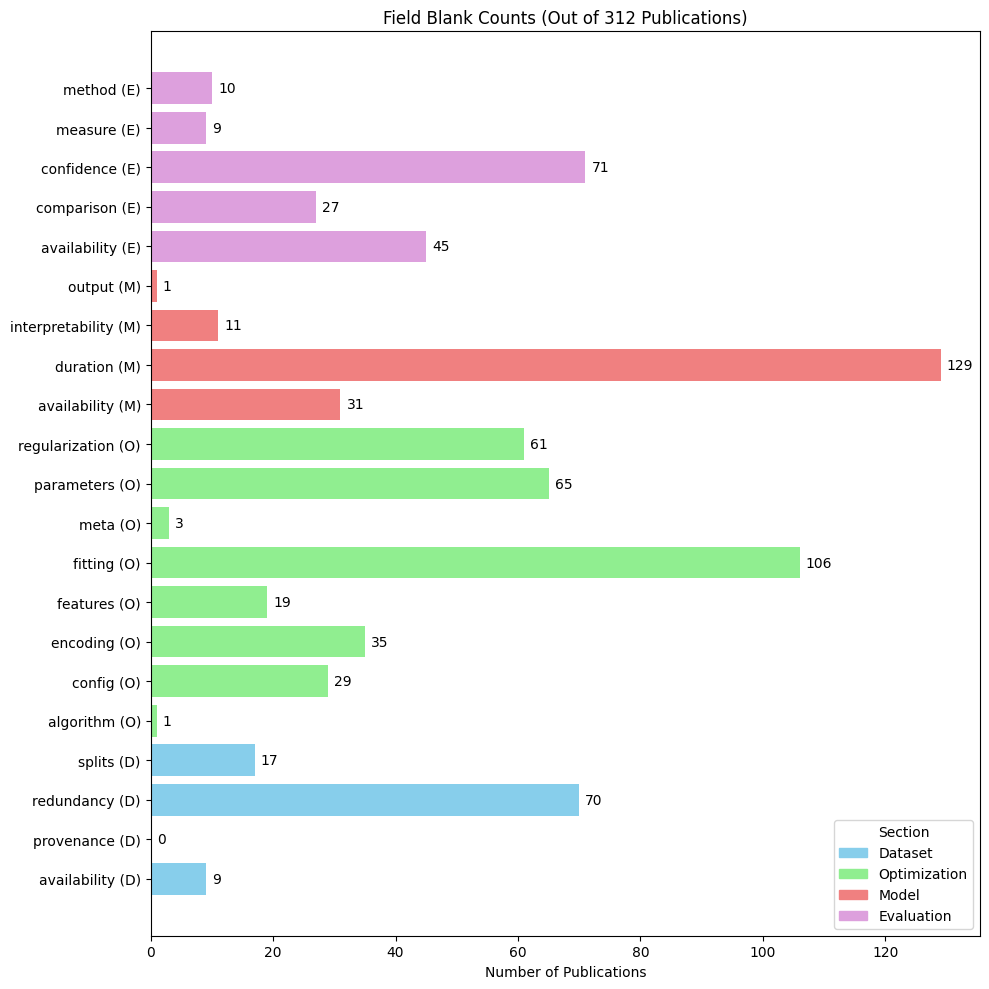

In [7]:
# Blank counts data
data = dict_blank_field_count

# Color mapping per category
color_map = {
    'dataset': 'skyblue',
    'optimization': 'lightgreen',
    'model': 'lightcoral',
    'evaluation': 'plum'
}

# Flatten data
flat_keys = []
flat_values = []
colors = []
categories = []

for category, subdict in data.items():
    for subkey, value in subdict.items():
        flat_keys.append(f"{subkey} ({category[0].upper()})")
        flat_values.append(value)
        colors.append(color_map[category])
        categories.append(category)

# Plot
plt.figure(figsize=(10, 10))  # Taller figure for horizontal layout
bars = plt.barh(flat_keys, flat_values, color=colors)  # Horizontal bars

plt.xlabel("Number of Publications")
plt.title("Field Blank Counts (Out of 312 Publications)")

# Annotate each bar with value
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, str(width), ha='left', va='center', fontsize=10)

# Legend
legend_patches = [mpatches.Patch(color=color, label=cat.capitalize()) for cat, color in color_map.items()]
plt.legend(handles=legend_patches, title="Section", loc='lower right')

plt.tight_layout()
plt.savefig(path_figure0, dpi=300, bbox_inches='tight')
plt.show()


**Skipped Field Count**

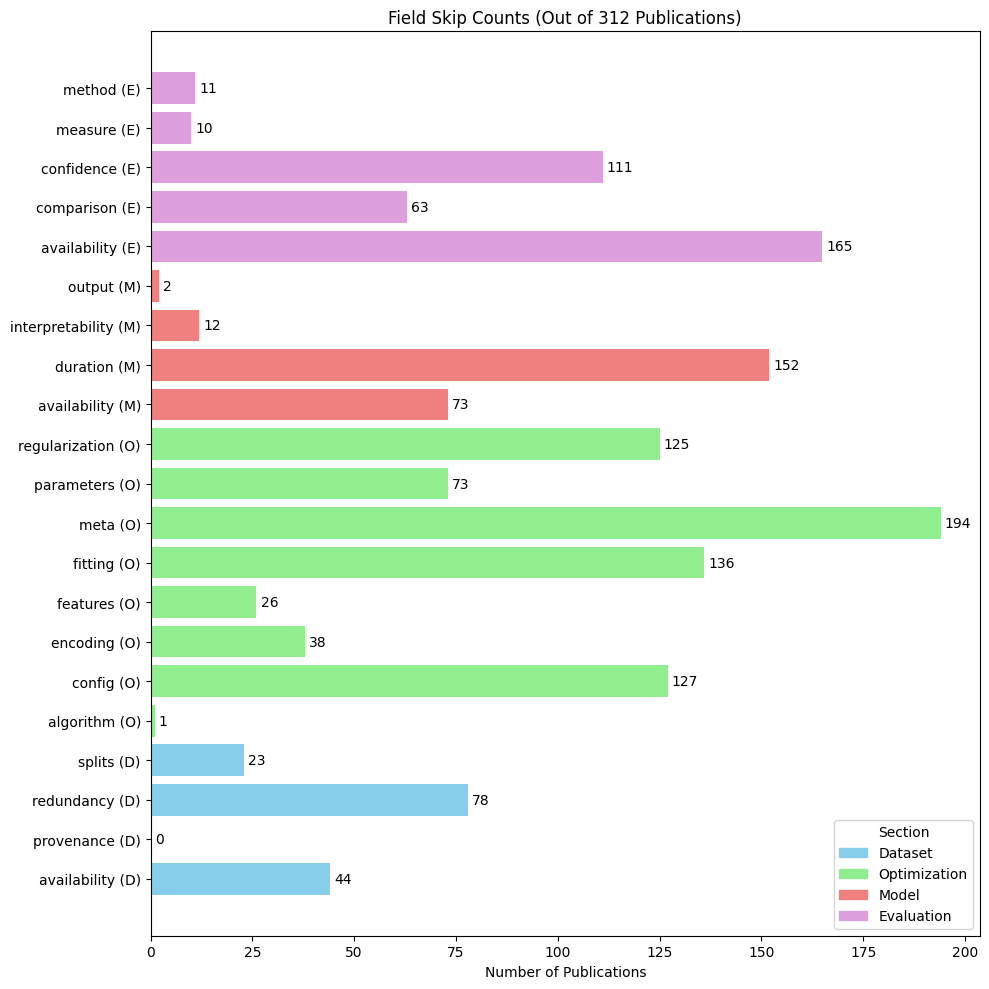

In [8]:
# Skip counts data
data = dict_skip_field_count

# Color mapping per category
color_map = {
    'dataset': 'skyblue',
    'optimization': 'lightgreen',
    'model': 'lightcoral',
    'evaluation': 'plum'
}

# Flatten data
flat_keys = []
flat_values = []
colors = []
categories = []

for category, subdict in data.items():
    for subkey, value in subdict.items():
        flat_keys.append(f"{subkey} ({category[0].upper()})")
        flat_values.append(value)
        colors.append(color_map[category])
        categories.append(category)

# Plot
plt.figure(figsize=(10, 10))  # Taller figure for horizontal layout
bars = plt.barh(flat_keys, flat_values, color=colors)  # Horizontal bars

plt.xlabel("Number of Publications")
plt.title("Field Skip Counts (Out of 312 Publications)")

# Annotate each bar with value
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, str(width), ha='left', va='center', fontsize=10)

# Legend
legend_patches = [mpatches.Patch(color=color, label=cat.capitalize()) for cat, color in color_map.items()]
plt.legend(handles=legend_patches, title="Section", loc='lower right')

plt.tight_layout()
plt.savefig(path_figure1, dpi=300, bbox_inches='tight')
plt.show()


### 2.2. Figure 2: SCORE distribution of the 317 publications.

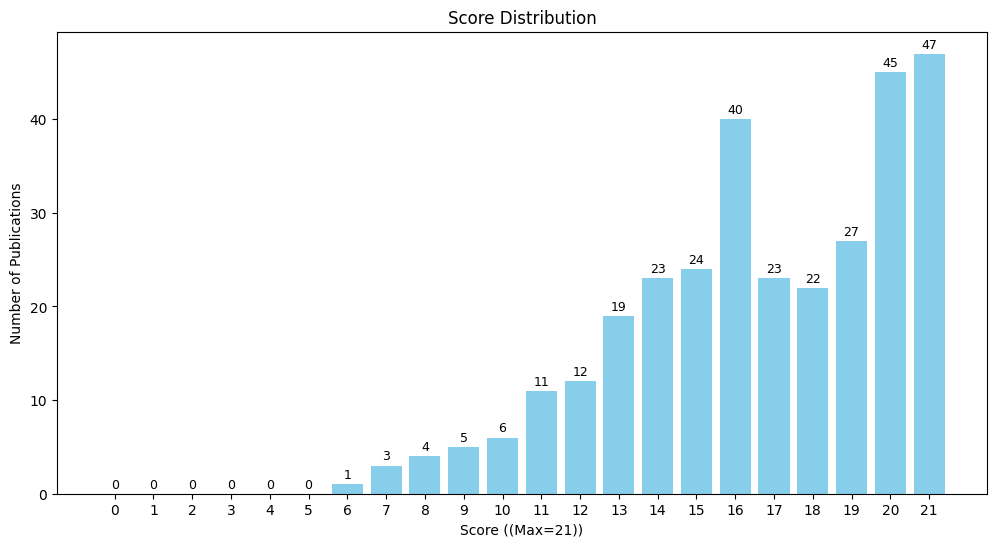

In [9]:
# Score list — []
scores = [entry['score'] for entry in list_entries]

# Count frequency of each score from 0 to 21
score_range = list(range(0, 22))  # 0 to 21
score_counts = Counter(scores)
frequencies = [score_counts.get(score, 0) for score in score_range]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(score_range, frequencies, color='skyblue')

# Labels & title
plt.xticks(score_range)
plt.xlabel("Score ((Max=21))")
plt.ylabel("Number of Publications")
plt.title("Score Distribution")

# Annotate each bar with its value
for bar, count in zip(bars, frequencies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, str(count), 
             ha='center', va='bottom', fontsize=9)

# Save the figure
plt.savefig(path_figure2, dpi=300, bbox_inches='tight')
plt.show()

### 2.3. Year-Publications

In [12]:
# generate dictionary for Year: number of publications 
dict_year_publications = {}
for entry in list_entries:
    year = entry['publication']['year']
    if not year.isnumeric():
        continue
    
    _id = entry['_id']
    if year in dict_year_publications:
        dict_year_publications[year]['count'] = dict_year_publications[year]['count'] + 1
        dict_year_publications[year]['_ids'].append(_id)
    else:
        dict_year_publications[year] = {'count': 1, '_ids': [_id]}
dict_year_publications['2020']

{'count': 37,
 '_ids': ['63516fedb9c880af1f305b1b',
  '63516fedb9c880af1f305b23',
  '63516fedb9c880af1f305b24',
  '63516fedb9c880af1f305b25',
  '63516fedb9c880af1f305b26',
  '63516fedb9c880af1f305b27',
  '63516fedb9c880af1f305b28',
  '63516fedb9c880af1f305b29',
  '63516fedb9c880af1f305b2f',
  '63516fedb9c880af1f305b30',
  '63516fedb9c880af1f305b32',
  '63516fedb9c880af1f305b33',
  '63516fedb9c880af1f305b4f',
  '63516fedb9c880af1f305b50',
  '63516fedb9c880af1f305b51',
  '63516fedb9c880af1f305b52',
  '63516fedb9c880af1f305b53',
  '63516fedb9c880af1f305b54',
  '63516fedb9c880af1f305b55',
  '63516fedb9c880af1f305b6f',
  '63516fedb9c880af1f305b70',
  '63516fedb9c880af1f305b71',
  '63516fedb9c880af1f305b72',
  '63516fedb9c880af1f305b7f',
  '63516fedb9c880af1f305b80',
  '63516fedb9c880af1f305b8c',
  '63516fedb9c880af1f305b8d',
  '63516fedb9c880af1f305b92',
  '63516fedb9c880af1f305b9a',
  '63516fedb9c880af1f305b9b',
  '63516fedb9c880af1f305ba4',
  '63516fedb9c880af1f305ba5',
  '63516fedb9c880a

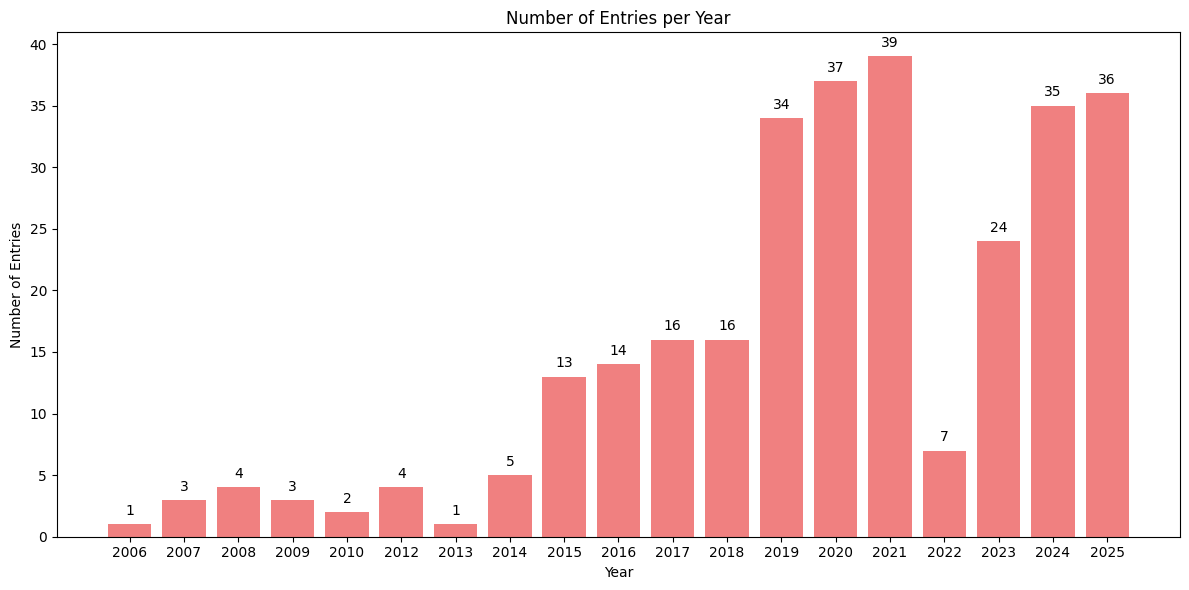

In [13]:

# Step 1: Extract and sort years
years = sorted(dict_year_publications.keys())
counts = [dict_year_publications[year]['count'] for year in years]

# Step 2: Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(years, counts, color='lightcoral')
plt.title("Number of Entries per Year")
plt.xlabel("Year")
plt.ylabel("Number of Entries")

# Annotate bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, str(count),
             ha='center', va='bottom', fontsize=10)

# Save & show
plt.tight_layout()
plt.savefig(path_figure3, dpi=300)
plt.show()

### 2.4. Curator--Publications

In [15]:
dict_user_publications = {} # {'user_id': {'name': , 'publication_ids': []}}
for entry in list_entries:
    usr_id =  entry['user']['_id']
    if usr_id in dict_user_publications:
        dict_user_publications[usr_id]['publication_ids'].append(entry['_id'])
    else:
        dict_user_publications[usr_id] = {'publication_ids': [entry['_id']]}
        
for usr_id, pub in dict_user_publications.items():
    list_pub_id = pub['publication_ids']
    list_score = [dict_entries[_id]['score'] for _id in list_pub_id]
    avg_score = sum(list_score)/len(list_pub_id)
    
    dict_user_publications[usr_id]['usr_id'] = usr_id
    dict_user_publications[usr_id]['num_pub'] = len(list_pub_id)
    dict_user_publications[usr_id]['scores'] = list_score
    dict_user_publications[usr_id]['avg_score'] = avg_score

In [2]:
# pd.DataFrame.from_dict(dict_user_publications, orient='index').sort_values(by=['num_pub', 'avg_score'])

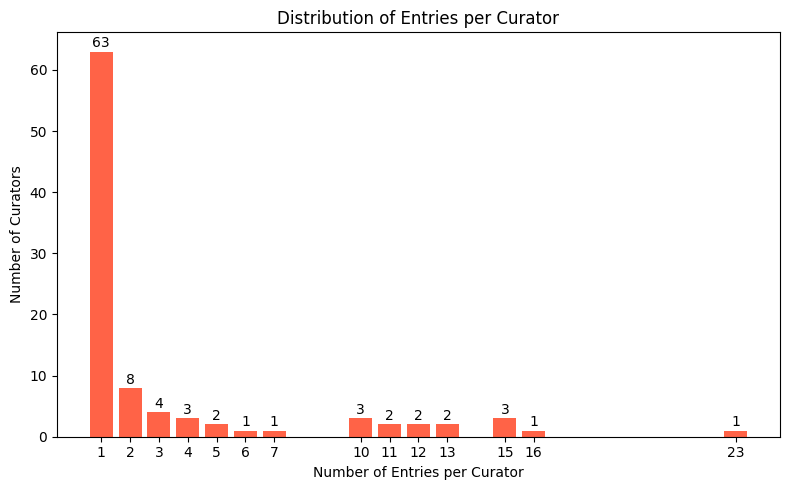

In [16]:
# Count how many curators have each num_pub value
counts = Counter([c['num_pub'] for _, c in dict_user_publications.items()])
df = pd.DataFrame(sorted(counts.items()), columns=['Num_Entries', 'Num_Curators'])

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(df['Num_Entries'], df['Num_Curators'], color='tomato')

plt.xticks(df['Num_Entries'])

plt.xlabel("Number of Entries per Curator")
plt.ylabel("Number of Curators")
plt.title("Distribution of Entries per Curator")

# Annotate counts on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, str(height),
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(path_figure4, dpi=300)
plt.show()

### 2.4. Curator--Score

Do some curators consistently ignore certain fields to publications compared to others?

In [17]:
len([{k:v} for k, v in dict_user_publications.items() if v['num_pub']>=10])

14

/tmp/ipykernel_143004/4020492459.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='Curator', x='Score', data=df, palette='Set3', width=0.4)  # horizontal + narrow boxes


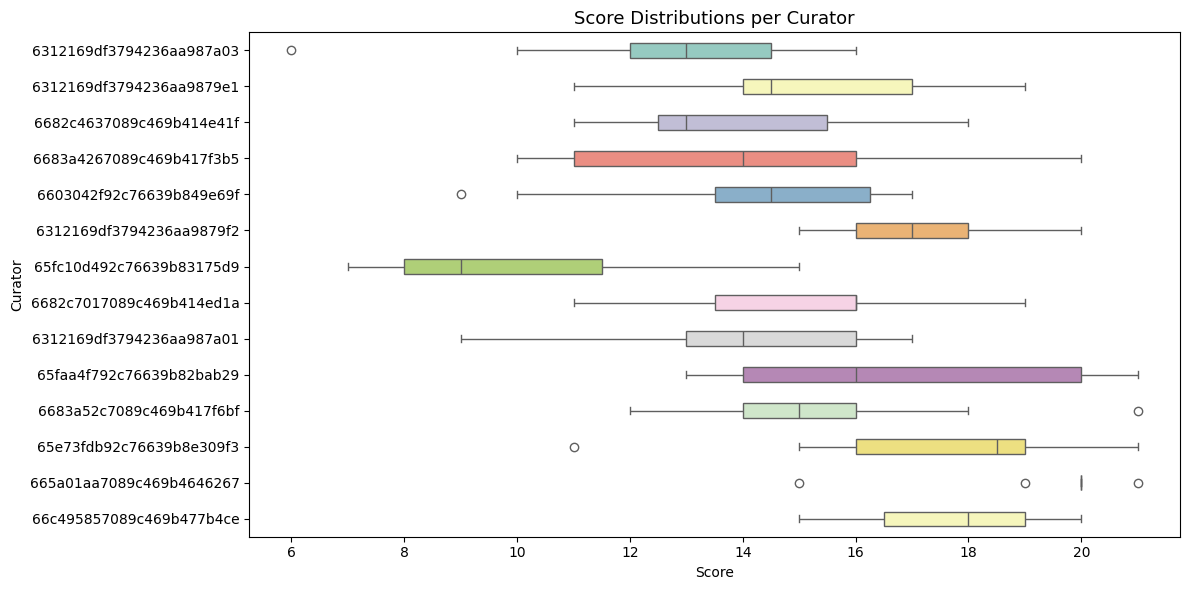

In [19]:
curators = [v for _, v in dict_user_publications.items() if v['num_pub']>=10]

# Flatten to DataFrame
rows = []
for curator in curators:
    for pub_id, score in zip(curator['publication_ids'], curator['scores']):
        rows.append({
            'Curator': curator['usr_id'],
            'Publication': pub_id,
            'Score': score
        })

df = pd.DataFrame(rows)

# Horizontal, narrow boxplot
plt.figure(figsize=(12, 6))  # smaller width, taller height for clarity
sns.boxplot(y='Curator', x='Score', data=df, palette='Set3', width=0.4)  # horizontal + narrow boxes

plt.title("Score Distributions per Curator", fontsize=13)
plt.xlabel("Score")
plt.ylabel("Curator")
plt.tight_layout()
plt.savefig(path_figure4_1, dpi=300)
plt.show()

In [20]:
# Group scores by curator
score_groups = [df[df['Curator'] == curator]['Score'].values for curator in df['Curator'].unique()]

# Kruskal-Wallis test (non-parametric)
stat, p = kruskal(*score_groups)
print(f"Kruskal-Wallis H-test: H={stat:.2f}, p={p:.4f}")

if p < 0.05:
    print("Significant difference in scoring between curators.")
else:
    print("No significant difference detected.")


Kruskal-Wallis H-test: H=94.30, p=0.0000
Significant difference in scoring between curators.


## 3. LLM summarizing Answers


3.1. summarize the user's answers, especially for answers including Y/N. 4 Sections: dataset, optimization, model and evaluation.
> For Model: Availablity, license!!

3.2. Analysis on 3.1.

**Load model**

In [2]:
# load summerize model
summarizer = Summarizer(model_name="deepseek-ai/deepseek-coder-1.3b-base", task = "optimization.algorithm")

/home/dimeng/miniconda3/envs/deepseek-env/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Using CUDA!


### 3.1. Summary User Answers
4 Sections: dataset, optimization, model and evaluation.

#### a. Dataset.availability

Keys:

['availability',
 'provenance',
 'redundancy',
 'splits',
 'done',
 'skip',
 'availability_label']

In [6]:
list_entries = read_json2list(P.path_registry_data_processed_json)
dict_entries = listEntries_to_dictEntries(list_entries)
len(list_entries)

312

In [7]:
for entry in list_entries:
    print(entry['_id'])
    print(entry['dataset']['availability'])
    # print(entry['dataset']['availability_label'])
    print(entry['dataset']['availability_llm'])
    print(entry['dataset']['availability_license'])
    print()

63516fedb9c880af1f305b1b

no
no

63516fedb9c880af1f305b1c
Yes :  data to reproduce the results can be downloaded from GitHub (https://github.com/ggonzalezp/hyperfoods).  All data were extracted from publicly available databases.
yes
no

63516fedb9c880af1f305b1d
The materials, data, code and associated protocols are available to readers with application to the corresponding author and Waitemata privacy, security and governance group with a limited data sharing agreement.     
yes
yes

63516fedb9c880af1f305b1e
Yes (GEO: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE152075)
yes
no

63516fedb9c880af1f305b1f
All data included in this study is available upon request at ELIXIR Luxemburg ( https://doi.org/10.17881/th9v-xt85 )
request
no

63516fedb9c880af1f305b20
Yes, Data are available from the Clinical Research Committee of KOBIO under the Korean College of Rheumatology for researchers who meet the criteria for access to confidential data
yes
no

63516fedb9c880af1f305b21
Additional fi

**Label dataset.availability**

In [ ]:
summarizer.change_task('dataset.availability')
for entry in list_entries:
    availability = entry['dataset']['availability']
    if availability=="":
        entry['dataset']['availability_llm'] = 'no'
        continue
    
    entry['dataset']['availability_llm'] = summarizer.summarize(availability)

Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['yes']
['yes']
['request']
['yes']
['yes']
['yes']
['no']
['request']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['no']
['request']
['yes']
['yes']
['yes']
['yes']
['request']
['request']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['no']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['no']
['yes']
['yes']
['yes']
['yes']
['no']
['no']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['request']
['no']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['yes']
['no']
['yes']
['yes']
['yes']
['yes']
['request']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['no']
['no']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['yes']
['yes']
['yes']
['yes']
['no']
['yes']
['request']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['no']
['no']
['yes']
['yes']
['yes']
['request']
['no']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['no']
['request']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['yes']
['no']
['no']
['yes']
['yes']
['no']
['yes']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['yes']
['no']
['yes']
['yes']
['yes']
['yes']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['no']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['request']
['yes']
['yes']
['yes']
['yes']
['yes']
['yes']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['no']
['no']
['no']
['yes']
['yes']
['yes']
['no']
['no']
['yes']
['request']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['no']
['no']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['yes']
['yes']
['no']
['yes']
['yes']
['yes']
['no']
['yes']
['no']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['no']
['no']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['no']
['yes']
['no']
['no']
['yes']
['yes']
['no']
['yes']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['no']
['no']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['no']
['yes']
['no']
['no']
['yes']
['yes']
['yes']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['request']
['no']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['request']
['yes']
['no']
['request']
['yes']
['yes']
['yes']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['yes']
['yes']
['yes']
['yes']
['yes']
['no']
['yes']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['no']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['yes']
['yes']
['no']
['no']
['request']
['yes']
['no']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['yes']
['yes']
['no']
['yes']
['yes']
['yes']
['yes']
['request']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['no']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['yes']
['yes']
['yes']
['yes']
['no']
['no']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['yes']
['yes']
['yes']
['yes']
['request']
['yes']
['yes']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['yes']
['yes']
['yes']
['yes']
['yes']
['yes']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['yes']
['yes']
['yes']
['yes']
['yes']
['yes']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['yes']
['yes']
['yes']
['yes']
['yes']
['yes']
['yes']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['yes']


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


['yes']
['yes']
['yes']
['yes']
['yes']
['yes']


KeyboardInterrupt: 

**Label License availability**

In [ ]:
summarizer.change_task('dataset.license') # update task

for entry in list_entries:
    availability = entry['dataset']['availability']
    if availability=="":
        entry['dataset']['availability_license'] = 'no'
        continue
    # print(availability)
    entry['dataset']['availability_license'] = summarizer.summarize(availability)
    # print(summarizer.summarize(availability))

Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end gene

**Save New JSON file**

In [ ]:
dump_list2json(list_entries, P.path_registry_data_processed_json)

#### b. Optimization

(1) Extarct ML methods from optimization.algorithm. A list of methods for each publication.
> Number of each methods been used;
> connect it with year of publication

(2) Count the number of publications using other methods (meta-predictions)

(3) Extract data encoding methods, similar as ML methods

Start with extracting information.

##### b.1. Algorithm

In [2]:
list_entries = read_json2list(P.path_registry_data_processed_json)
dict_entries = listEntries_to_dictEntries(list_entries)
len(list_entries)

312

In [7]:
'''
for entry in list_entries:
    # print("Answer ID: ", entry['_id'])
    print(entry['optimization']['algorithm_names'])
    print(entry['optimization']['algorithm_category'])
    print()
'''

'\nfor entry in list_entries:\n    # print("Answer ID: ", entry[\'_id\'])\n    print(entry[\'optimization\'][\'algorithm_names\'])\n    print(entry[\'optimization\'][\'algorithm_category\'])\n    print()\n'

In [ ]:
summarizer.change_task('optimization.algorithm')
for entry in list_entries:
    algorithm = entry['optimization']['algorithm']
    if algorithm=="":
        entry['optimization']['algorithm_list'] = []
        continue
    
    print(entry['_id'])
    
    algorithms = summarizer.summarize(algorithm)
    # result = summarizer.normalize_algorithms(raw_result)
    entry['optimization']['algorithm_list'] = algorithms

**Unify Methods Names**

In [3]:
for entry in list_entries:
    algorithm_list = entry['optimization']['algorithm_list']
    if len(algorithm_list)==0:
        entry['optimization']['algorithm_names'] = []
        entry['optimization']['algorithm_category'] = []
        continue
    
    algorithm_names = normalize_algorithms(algorithm_list)[0]
    entry['optimization']['algorithm_names'] = algorithm_names
    entry['optimization']['algorithm_category'] = method2category(algorithm_names)

**Save JSON file**

In [4]:
dump_list2json(list_entries, P.path_registry_data_processed_json)

##### b.2. Using Predicotrs

In [3]:
list_entries = read_json2list(P.path_registry_data_processed_json)
dict_entries = listEntries_to_dictEntries(list_entries)
len(list_entries)

312

In [4]:
summarizer.change_task('optimization.meta')
for entry in list_entries:
    meta = entry['optimization']['meta']
    if meta=="":
        entry['optimization']['meta_label'] = 'no'
        continue
    
    meta_label = summarizer.summarize(meta)
    entry['optimization']['meta_label'] = meta_label

Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.


Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end gene

**Save JSON file**

In [6]:
dump_list2json(list_entries, P.path_registry_data_processed_json)

##### b.3. Model config availablity

In [3]:
list_entries = read_json2list(P.path_registry_data_processed_json)
dict_entries = listEntries_to_dictEntries(list_entries)
len(list_entries)

312

In [ ]:
summarizer.change_task('optimization.config')
for entry in list_entries:
    config = entry['optimization']['config']
    
    if config=="":
        entry['optimization']['config_label'] = 'no'
        continue
    
    config_label = summarizer.summarize(config)
    # print(config_label)
    entry['optimization']['config_label'] = config_label

**Save JSON file**

In [6]:
dump_list2json(list_entries, P.path_registry_data_processed_json)

#### c. Model

##### c.1. Model.availablity

In [3]:
list_entries = read_json2list(P.path_registry_data_processed_json)
dict_entries = listEntries_to_dictEntries(list_entries)
len(list_entries)

312

In [10]:
list_entries[0]['model']

{'availability': 'The MATLAB package of OH-PRED is available as Supplementary files.',
 'duration': '',
 'interpretability': 'Black box',
 'output': 'Classification.',
 'done': 3,
 'skip': 1}

In [6]:
summarizer.change_task('model.availability')
for entry in list_entries:
    availability = entry['model']['availability']
    
    if availability=="":
        entry['model']['availability_label'] = 'no'
        continue
    
    availability_label = summarizer.summarize(availability)
    # print(availability_label)
    entry['model']['availability_label'] = availability_label

Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:32014 for open-end gene

**Save JSON file**

In [8]:
dump_list2json(list_entries, P.path_registry_data_processed_json)

##### c.2. Model.license

In [3]:
list_entries = read_json2list(P.path_registry_data_processed_json)
dict_entries = listEntries_to_dictEntries(list_entries)
len(list_entries)

312

In [6]:
for entry in list_entries:
    print(entry['_id'])
    print(entry['model']['availability'])
    print(entry['model']['license'])
    print()

63516fedb9c880af1f305b1b
The MATLAB package of OH-PRED is available as Supplementary files.
yes

63516fedb9c880af1f305b1c
The code to reproduce the results can be downloaded from GitHub (https://github.com/ggonzalezp/hyperfoods)
no

63516fedb9c880af1f305b1d
The materials, data, code and associated protocols are available to readers with application to the corresponding author and Waitemata privacy, security and governance group with a limited data sharing agreement.
yes

63516fedb9c880af1f305b1e
No
no

63516fedb9c880af1f305b1f
https://lbai-infolab.github.io/SjTree/
yes

63516fedb9c880af1f305b20

no

63516fedb9c880af1f305b21
https://github.com/jlanga/smsk_popoolation, MIT License
yes

63516fedb9c880af1f305b22
https://github.com/stanfordmlgroup/influenza-qtof
yes

63516fedb9c880af1f305b23
No
no

63516fedb9c880af1f305b24
Data is available from authors upon request.
no

63516fedb9c880af1f305b25
yes, GitLab https://gitlab.com/mgarciat/genome-wide-prediction-of-topoisomerase-iibeta-binding
y

In [ ]:
summarizer.change_task('model.license')
for entry in list_entries:
    availability = entry['model']['availability']
    
    if availability=="":
        entry['model']['license'] = 'no'
        continue
    
    license_label = summarizer.summarize(availability)
    print(license_label)
    entry['model']['license'] = license_label

**Save JSON file**

In [7]:
dump_list2json(list_entries, P.path_registry_data_processed_json)

### 3.2. Analysis on the User Answers

>1. Table: availability (Dataset, Hyperparameter Configuration, and Model)
>2. 

In [32]:
list_entries = read_json2list(P.path_registry_data_processed_json)
dict_entries = listEntries_to_dictEntries(list_entries)
len(list_entries)

312

#### a. Availability

In [21]:
num_avail_dataset = {'yes':0, 'request':0, 'no':0}
num_avail_model = {'yes':0, 'request':0, 'no':0}
# num_avail_config = {'yes':0, 'request':0, 'no':0}

num_avail_dataset_license = {'yes':0, 'no':0}
num_avail_model_license = {'yes':0, 'no':0}

for entry in list_entries:
    dataset = entry['dataset']
    model = entry['model']
    num_avail_dataset[dataset['availability_llm']] = num_avail_dataset[dataset['availability_llm']] + 1
    num_avail_dataset_license[dataset['availability_license']] = num_avail_dataset_license[dataset['availability_license']] + 1
    
    num_avail_model[model['availability_label']] = num_avail_model[model['availability_label']] + 1
    num_avail_model_license[model['license']] = num_avail_model_license[model['license']] + 1

num_avail_dataset, num_avail_model, num_avail_dataset_license, num_avail_model_license

({'yes': 227, 'request': 19, 'no': 66},
 {'yes': 218, 'request': 3, 'no': 91},
 {'yes': 93, 'no': 219},
 {'yes': 183, 'no': 129})

#### b. Computational Methods

Plot Year and Number of publications.

Separate year into several chunks. Year-ML, availibility, ...

In [13]:
list_entries[1]['optimization']

{'algorithm': 'A  non-linear, multi-layer convolutional Graph Neural Network (GNN) was trained to encode drug features, which were then fed to a Multi-Layer Perceptron (MLP) to output a probability distribution.  The probability distributions were passed to a SVM for the binary classification of nodes. The training was end-to-end.',
 'config': 'Yes. Hyperparameter settings for every method are reported. For neural models, hyperparameter candidates can be found in Table 1, Characteristics of the neural network models architecture can be found in text.',
 'encoding': 'Initially, each drug (or food molecule) is represented by a graph G of human PPI (with 15135 nodes and 177848 edges), with one binary feature per node (1 for anti-cancer, 0 for non anti-cancer).     A vector representation of the graph G is computed using a Graph Encoder, i.e. a GNN, which learns the systemic effect of drugs (or food molecules) on the PPI network.    ',
 'features': 'Initial f0) = number of genes x number o

In [24]:
dict_algorithm_count = {}
for entry in list_entries:
    for alg in entry['optimization']['algorithm_names']:
        if alg in dict_algorithm_count:
            dict_algorithm_count[alg]['count'] = dict_algorithm_count[alg]['count'] + 1
        else:
            dict_algorithm_count[alg] = {'method': alg, 'count': 1, 'category': method2category([alg])[0]}

In [20]:
dict_algorithm_count

{'svm': {'method': 'svm', 'count': 73, 'category': 'Traditional ML'},
 'gnn': {'method': 'gnn', 'count': 10, 'category': 'Deep Learning'},
 'mlp': {'method': 'mlp', 'count': 16, 'category': 'Deep Learning'},
 'neural network': {'method': 'neural network',
  'count': 72,
  'category': 'Deep Learning'},
 'decision tree': {'method': 'decision tree',
  'count': 15,
  'category': 'Traditional ML'},
 'gradient boosting': {'method': 'gradient boosting',
  'count': 21,
  'category': 'Traditional ML'},
 'lasso': {'method': 'lasso', 'count': 5, 'category': 'Statistical Methods'},
 'rf': {'method': 'rf', 'count': 77, 'category': 'Traditional ML'},
 'xgboost': {'method': 'xgboost', 'count': 9, 'category': 'Traditional ML'},
 'naive bayes': {'method': 'naive bayes',
  'count': 13,
  'category': 'Bayesian / Probabilistic'},
 'cnn': {'method': 'cnn', 'count': 35, 'category': 'Deep Learning'},
 'regression': {'method': 'regression',
  'count': 3,
  'category': 'Statistical Methods'},
 'logistic regres

In [25]:
df_data = pd.DataFrame.from_dict(dict_algorithm_count, orient='index')
fig = px.treemap(
    df_data,
    path=["category", "method"],  # Grouping hierarchy
    values="count",
    color="category",
    title="Computational Methods by Category",
)

fig.update_traces(textinfo="label+value")
fig.write_html(path_figure5)
fig.write_image(path_figure6, width=1200, height=800)

fig.show()


**Save to Table**

In [26]:
df_data.to_csv(path_table2, index=None)

#### c. Computational Methods--Year

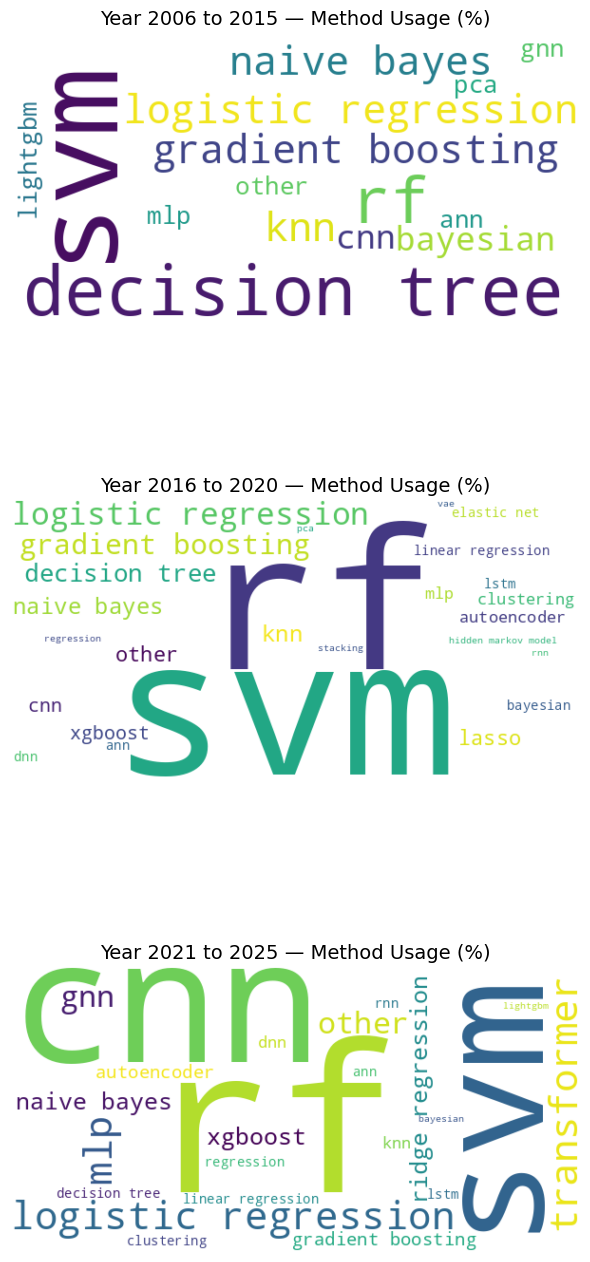

In [29]:
data_CM_year = []
for entry in list_entries:
    y = entry['publication']['year']
    
    if not y.isnumeric(): # not published yet
        continue
    
    if int(y) <= 2015:
        y='2006 to 2015'
    # elif int(y) <= 2015:
    #     y='2011 to 2015'
    elif int(y) <= 2020:
        y='2016 to 2020'
    elif int(y) <= 2025:
        y='2021 to 2025'
    
    method = entry['optimization']['algorithm_names']
    if 'neural network' in method: method.remove('neural network')
    
    if len(method)==0:
        continue
        
    d = {
        'Year': y,
        'Method': method
        }
    data_CM_year.append(d)

# Step 2: Flatten to one row per method per year
rows = []
for entry in data_CM_year:
    year = entry["Year"]
    for method in entry["Method"]:
        rows.append({"Year": year, "Method": method})

df = pd.DataFrame(rows)

# Step 3: Prepare vertical layout
years = sorted(df["Year"].unique())
fig, axes = plt.subplots(len(years), 1, figsize=(6, 5 * len(years)))

if len(years) == 1:
    axes = [axes]

for ax, year in zip(axes, years):
    year_data = df[df["Year"] == year]
    total = len(year_data)
    freq = year_data["Method"].value_counts()
    freq_percent = (freq / total * 100).round(1).to_dict()  # percentage values

    # WordCloud uses frequencies; we scale them as-is (font size reflects %)
    wc = WordCloud(width=600, height=300, background_color="white")
    wc.generate_from_frequencies(freq_percent)

    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(f"Year {year} — Method Usage (%)", fontsize=14)
    ax.axis("off")

plt.tight_layout()
plt.savefig(path_figure7, dpi=300)
plt.show()

## 4. SCORE -- Citations

In [3]:
list_entries = read_json2list(P.path_registry_data_processed_json)
dict_entries = listEntries_to_dictEntries(list_entries)
len(list_entries)
list_entries[0]['publication']

{'pmid': '32344344',
 'updated': '03/22/2022 11:54:11',
 'authors': 'Bouysset C, Belloir C, Antonczak S, Briand L, Fiorucci S',
 'journal': 'Food Chem',
 'title': 'Novel scaffold of natural compound eliciting sweet taste revealed by machine learning.',
 'doi': '10.1016/j.foodchem.2020.126864',
 'year': '2020',
 'done': 0,
 'skip': 0,
 'tags': [],
 'clear_doi': '10.1016/j.foodchem.2020.126864',
 'clear_pmid': '32344344',
 'pmcid': '',
 'num_citation': 29}

### 4.1. Get the number of citations

>  OpenAlex API

In [ ]:
list_entries = read_json2list(P.path_registry_data_processed_json)
dict_entries = listEntries_to_dictEntries(list_entries)

for entry in list_entries:
    doi = entry['publication']['clear_doi']
    result = get_openalex_citations_by_doi(doi)
    if result is not None:
        entry['publication']['num_citation'] = result['cited_by_count']
    else:
        entry['publication']['num_citation'] = -1

Error 404: <!doctype html>
<html lang=en>
<title>404 Not Found</title>
<h1>Not Found</h1>
<p>The requested URL was not found on the server. If you entered the URL manually please check your spelling and try again.</p>

Error 404: <!doctype html>
<html lang=en>
<title>404 Not Found</title>
<h1>Not Found</h1>
<p>The requested URL was not found on the server. If you entered the URL manually please check your spelling and try again.</p>

Error 404: <!doctype html>
<html lang=en>
<title>404 Not Found</title>
<h1>Not Found</h1>
<p>The requested URL was not found on the server. If you entered the URL manually please check your spelling and try again.</p>

Error 404: <!doctype html>
<html lang=en>
<title>404 Not Found</title>
<h1>Not Found</h1>
<p>The requested URL was not found on the server. If you entered the URL manually please check your spelling and try again.</p>

Error 404: <!doctype html>
<html lang=en>
<title>404 Not Found</title>
<h1>Not Found</h1>
<p>The requested URL was not found

**Save to JSON**

In [4]:
dump_list2json(list_entries, P.path_registry_data_processed_json)

### 4.2. Correlation: SCORE--Citations

In [2]:
list_entries = read_json2list(P.path_registry_data_processed_json)
dict_entries = listEntries_to_dictEntries(list_entries)
len(list_entries)
list_entries[0]['publication']

{'pmid': '32344344',
 'updated': '03/22/2022 11:54:11',
 'authors': 'Bouysset C, Belloir C, Antonczak S, Briand L, Fiorucci S',
 'journal': 'Food Chem',
 'title': 'Novel scaffold of natural compound eliciting sweet taste revealed by machine learning.',
 'doi': '10.1016/j.foodchem.2020.126864',
 'year': '2020',
 'done': 0,
 'skip': 0,
 'tags': [],
 'clear_doi': '10.1016/j.foodchem.2020.126864',
 'clear_pmid': '32344344',
 'pmcid': '',
 'num_citation': 29}

**function**

In [59]:
def corr_citation_score(df, title_keyword='ALL entries', path_plot=''):
    # log-transform citations if they're highly skewed
    df['log_citation'] = df['num_citation'].apply(lambda x: np.log1p(x))  # log(1 + x) handles zero

    # --- Scatter Plot ---
    plt.figure(figsize=(8, 6))
    sns.regplot(data=df, x='score', y='num_citation', scatter_kws={'alpha':0.6}, line_kws={"color":"red"})
    plt.xlabel("DOME Score")
    # plt.ylabel("Log(Number of Citations + 1)")
    plt.ylabel("Number of Citations per Year per Publication")
    plt.title(f"Relationship Between DOME Score and Yearly Citation Count\n({title_keyword})")
    plt.tight_layout()
    # plt.savefig("dome_vs_citations.png", dpi=300)
    plt.show()

    # --- Correlation Analysis ---
    pearson_r, pearson_p = pearsonr(df['score'], df['num_citation'])
    spearman_r, spearman_p = spearmanr(df['score'], df['num_citation'])

    print(f"Pearson Correlation: r = {pearson_r:.3f}, p = {pearson_p:.4f}")
    print(f"Spearman Correlation: r = {spearman_r:.3f}, p = {spearman_p:.4f}")
    
    return {'pearson_r': pearson_r, 'pearson_p':pearson_p, 'spearman_r': spearman_r, 'spearman_p':spearman_p}

In [57]:
list_score_citation = []
for entry in list_entries:
    if entry['publication']['year'].isnumeric(): 
        year = int(entry['publication']['year'])
    else: 
        year = 3000
        
    score = entry['score']
    citation = entry['publication']['num_citation']
    list_score_citation.append({'_id': entry['_id'], 'year': year, 'score': score, 'num_citation': citation})

df_data = pd.DataFrame.from_dict(list_score_citation)
df_data_less2024 = df_data[df_data['year']<2024]
df_data_less2024_cita1000 = df_data_less2024[df_data_less2024['num_citation']<1000]
df_data_less2024_cita1000_score10 = df_data_less2024_cita1000[df_data_less2024_cita1000['score']>=10]

df_data_less2024_cita1000_avgScore = df_data_less2024_cita1000.copy()
df_data_less2024_cita1000_avgScore['num_citation'] = [row['num_citation']/(2025-row['year']) for _, row in df_data_less2024_cita1000_avgScore.iterrows()]

df_data[:2], len(df_data), len(df_data_less2024)

(                        _id  year  score  num_citation
 0  63516fedb9c880af1f305b1b  2020     13            29
 1  63516fedb9c880af1f305b1c  2008     17             9,
 312,
 223)

**ALL years**

/tmp/ipykernel_172969/216763902.py:3: RuntimeWarning: divide by zero encountered in log1p
  df['log_citation'] = df['num_citation'].apply(lambda x: np.log1p(x))  # log(1 + x) handles zero


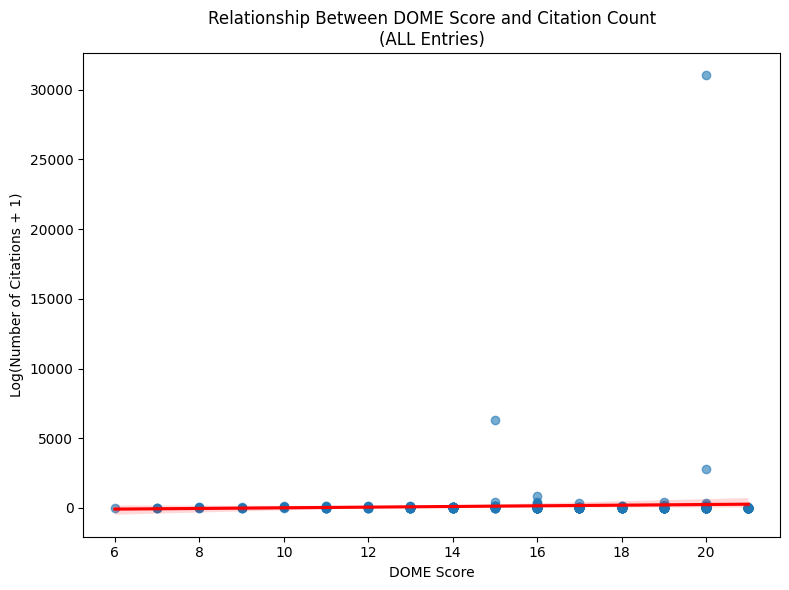

Pearson Correlation: r = 0.047, p = 0.4110
Spearman Correlation: r = -0.482, p = 0.0000


{'pearson_r': 0.04670584235847861,
 'pearson_p': 0.41100458404020995,
 'spearman_r': -0.48158957702702615,
 'spearman_p': 1.6069105914733397e-19}

In [24]:
corr_citation_score(df_data, title_keyword='ALL Entries')

**Year<2024**

/tmp/ipykernel_172969/216763902.py:3: RuntimeWarning: divide by zero encountered in log1p
  df['log_citation'] = df['num_citation'].apply(lambda x: np.log1p(x))  # log(1 + x) handles zero
/tmp/ipykernel_172969/216763902.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_citation'] = df['num_citation'].apply(lambda x: np.log1p(x))  # log(1 + x) handles zero


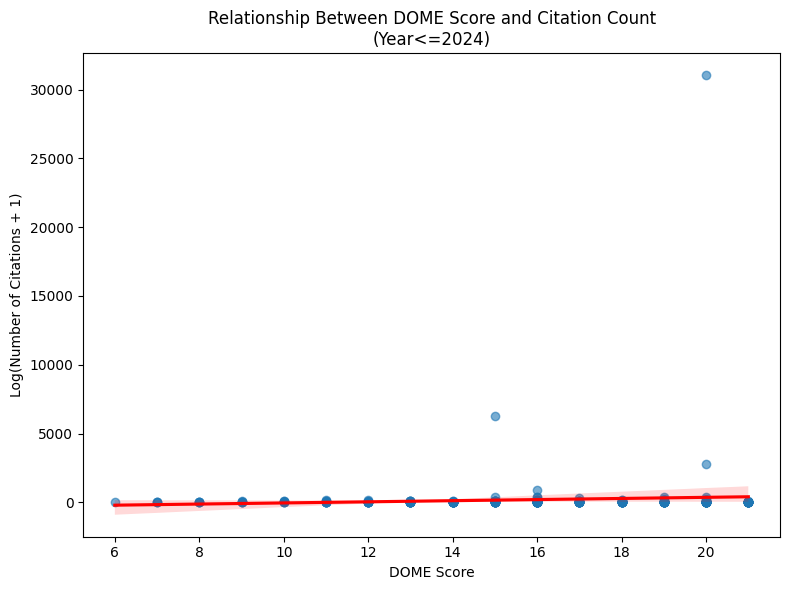

Pearson Correlation: r = 0.072, p = 0.2483
Spearman Correlation: r = -0.272, p = 0.0000


{'pearson_r': 0.0721249578440199,
 'pearson_p': 0.24834565257309735,
 'spearman_r': -0.27221722800519127,
 'spearman_p': 9.195806221673144e-06}

In [ ]:
corr_citation_score(df_data_less2024, title_keyword='Year<2024')

**Year<2024 & Num_citation<1000**

/tmp/ipykernel_172969/216763902.py:3: RuntimeWarning: divide by zero encountered in log1p
  df['log_citation'] = df['num_citation'].apply(lambda x: np.log1p(x))  # log(1 + x) handles zero
/tmp/ipykernel_172969/216763902.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_citation'] = df['num_citation'].apply(lambda x: np.log1p(x))  # log(1 + x) handles zero


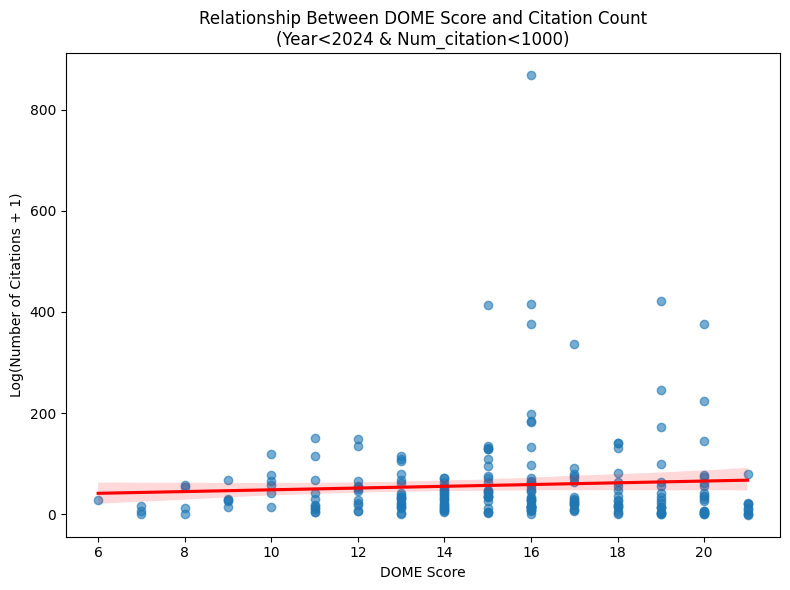

Pearson Correlation: r = 0.065, p = 0.3367
Spearman Correlation: r = -0.068, p = 0.3180


{'pearson_r': 0.06506649632143341,
 'pearson_p': 0.33674699181457546,
 'spearman_r': -0.06763056498117044,
 'spearman_p': 0.31801145268928777}

In [30]:
corr_citation_score(df_data_less2024_cita1000, title_keyword='Year<2024 & Num_citation<1000')

**Year<2024 & Num_citation<1000 & Score>=10**

/tmp/ipykernel_172969/216763902.py:3: RuntimeWarning: divide by zero encountered in log1p
  df['log_citation'] = df['num_citation'].apply(lambda x: np.log1p(x))  # log(1 + x) handles zero
/tmp/ipykernel_172969/216763902.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_citation'] = df['num_citation'].apply(lambda x: np.log1p(x))  # log(1 + x) handles zero


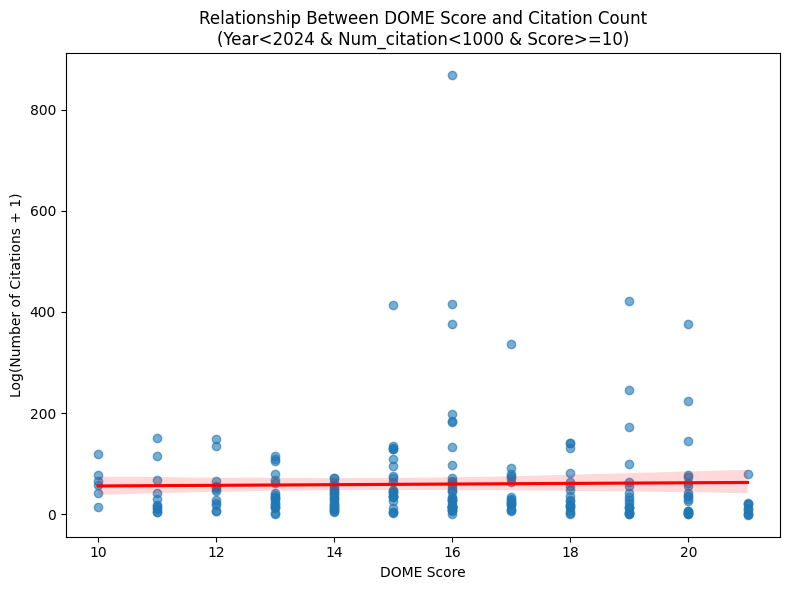

Pearson Correlation: r = 0.020, p = 0.7760
Spearman Correlation: r = -0.123, p = 0.0778


{'pearson_r': 0.019892345012614034,
 'pearson_p': 0.7760302430826332,
 'spearman_r': -0.12285860746487703,
 'spearman_p': 0.07779749095876899}

In [33]:
corr_citation_score(df_data_less2024_cita1000_score10, title_keyword='Year<2024 & Num_citation<1000 & Score>=10')

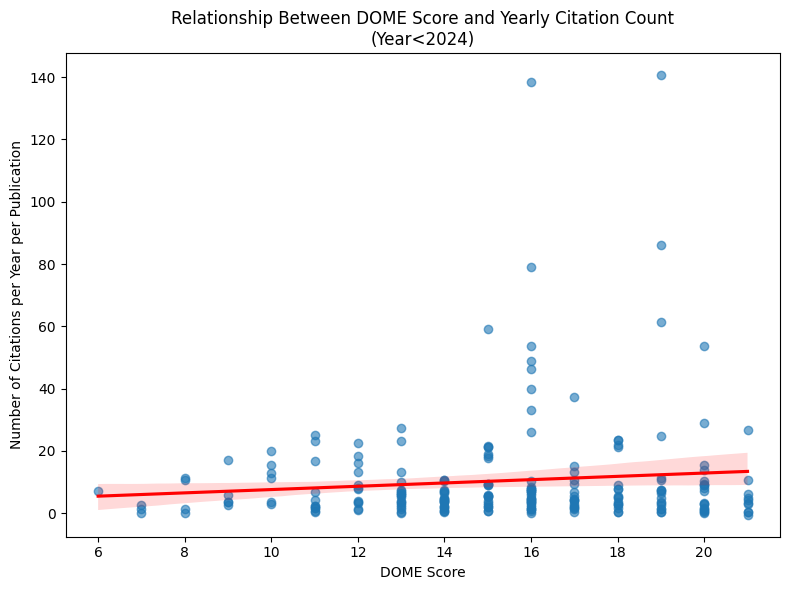

Pearson Correlation: r = 0.102, p = 0.1329
Spearman Correlation: r = 0.016, p = 0.8167


{'pearson_r': 0.10162501227102862,
 'pearson_p': 0.13292970060873932,
 'spearman_r': 0.015714553140729004,
 'spearman_p': 0.8167158945514384}

In [60]:
corr_citation_score(df_data_less2024_cita1000_avgScore, 'Year<2024')

In [44]:
df_data_less2024_cita1000_avgScore[:10]

,_id,year,score,num_citation,log_citation
0,63516fedb9c880af1f305b1b,2020,13,5.800000,1.916923
1,63516fedb9c880af1f305b1c,2008,17,0.529412,0.424883
2,63516fedb9c880af1f305b1d,2008,19,3.235294,1.443453
3,63516fedb9c880af1f305b1e,2019,12,22.500000,3.157000
4,63516fedb9c880af1f305b1f,2019,13,10.166667,2.412933
5,63516fedb9c880af1f305b20,2019,16,1.333333,0.847298
6,63516fedb9c880af1f305b21,2019,15,5.666667,1.897120
7,63516fedb9c880af1f305b22,2019,14,7.500000,2.140066
8,63516fedb9c880af1f305b23,2020,12,3.600000,1.526056
9,63516fedb9c880af1f305b24,2020,15,9.400000,2.341806
